<a href="https://colab.research.google.com/github/svandergoote/LGBIO2060-2021/blob/main/LGBIO2060_TP1_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LGBIO2060 Exercice session 1
__Authors:__ Simon Vandergooten and Clemence Vandamme

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy

Statistical reminder :
In this first exercise session we will refresh your memory about the basis of statistics needed for the rest of the sessions.
After this session you should be able to:
* Sample data from a specific probability distribution.
* Use basic probability rules to infer parameters.
* Understand and use the maximum likelihood principle.
* Understand the Bayes' rule and the impact of a prior in the inference.

## Imports and helper functions
**Please execute the cell(s) below to initialize the notebook environment.**

In [2]:
#Import the libraries 
import numpy as np #for the math stuff
import matplotlib.pyplot as plt #for the plot handling
import scipy as sp
from scipy.stats import norm
from numpy.random import default_rng   # a default random number generator

In [3]:
#@title Figure Settings
import ipywidgets as widgets  # interactive display
from ipywidgets import interact, fixed, HBox, Layout, VBox, interactive, Label, interact_manual
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

In [4]:
#@title Plotting Functions

def plot_random_sample(x, y, figtitle = None):
    """ Plot the random sample between 0 and 1 for both the x and y axes.

    Args:
        x (ndarray): array of x coordinate values across the random sample
        y (ndarray): array of y coordinate values across the random sample
        figtitle (str): title of histogram plot (default is no title)

    Returns:
        Nothing.
    """
    fig, ax = plt.subplots()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.xlim([-0.25, 1.25]) # set x and y axis range to be a bit less than 0 and greater than 1
    plt.ylim([-0.25, 1.25])
    plt.scatter(dataX, dataY)
    if figtitle is not None:
        fig.suptitle(figtitle, size=16)
    plt.show()

def plot_random_walk(x, y, figtitle = None):
    """ Plots the random walk within the range 0 to 1 for both the x and y axes.

    Args:
        x (ndarray): array of steps in x direction
        y (ndarray): array of steps in y direction
        figtitle (str): title of histogram plot (default is no title)

    Returns:
        Nothing.
    """
    fig, ax = plt.subplots()
    plt.plot(x,y,'b-o', alpha = 0.5)
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    ax.set_xlabel('x location')
    ax.set_ylabel('y location')
    plt.plot(x[0], y[0], 'go')
    plt.plot(x[-1], y[-1], 'ro')

    if figtitle is not None:
        fig.suptitle(figtitle, size=16)
    plt.show()

def plot_hist(data, xlabel, figtitle = None, num_bins = None):
    """ Plot the given data as a histogram.

    Args:
        data (ndarray): array with data to plot as histogram
        xlabel (str): label of x-axis
        figtitle (str): title of histogram plot (default is no title)
        num_bins (int): number of bins for histogram (default is 10)

    Returns:
        count (ndarray): number of samples in each histogram bin
        bins (ndarray): center of each histogram bin
    """
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    if num_bins is not None:
        count, bins, _ = plt.hist(data, bins = num_bins)
    else:
        count, bins, _ = plt.hist(data, bins = np.arange(np.min(data)-.5, np.max(data)+.6)) # 10 bins default
    if figtitle is not None:
        fig.suptitle(figtitle, size=16)
    plt.show()
    return count, bins

def my_plot_single(x, px):
    """
    Plots normalized Gaussian distribution

    Args:
        x (numpy array of floats):     points at which the likelihood has been evaluated
        px (numpy array of floats):    normalized probabilities for prior evaluated at each `x`

    Returns:
        Nothing.
  """
    if px is None:
        px = np.zeros_like(x)

    fig, ax = plt.subplots()
    ax.plot(x, px, '-', color='C2', LineWidth=2, label='Prior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')

def plot_gaussian_samples_true(samples, xspace, mu, sigma, xlabel, ylabel):
    """ Plot a histogram of the data samples on the same plot as the gaussian
    distribution specified by the give mu and sigma values.

    Args:
        samples (ndarray): data samples for gaussian distribution
        xspace (ndarray): x values to sample from normal distribution
        mu (scalar): mean parameter of normal distribution
        sigma (scalar): variance parameter of normal distribution
        xlabel (str): the label of the x-axis of the histogram
        ylabel (str): the label of the y-axis of the histogram

    Returns:
        Nothing.
    """
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # num_samples = samples.shape[0]

    count, bins, _ = plt.hist(samples, density=True)
    plt.plot(xspace, norm.pdf(xspace, mu, sigma),'r-')
    plt.show()
    
def plot_likelihoods(likelihoods, mean_vals, variance_vals):
    """ Plot the likelihood values on a heatmap plot where the x and y axes match
    the mean and variance parameter values the likelihoods were computed for.

    Args:
        likelihoods (ndarray): array of computed likelihood values
        mean_vals (ndarray): array of mean parameter values for which the
                            likelihood was computed
        variance_vals (ndarray): array of variance parameter values for which the
                            likelihood was computed

    Returns:
        Nothing.
    """
    fig, ax = plt.subplots()
    im = ax.imshow(likelihoods)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('log likelihood', rotation=-90, va="bottom")

    ax.set_xticks(np.arange(len(mean_vals)))
    ax.set_yticks(np.arange(len(variance_vals)))
    ax.set_xticklabels(mean_vals)
    ax.set_yticklabels(variance_vals)
    ax.set_xlabel('Mean')
    ax.set_ylabel('Variance')

def posterior_plot(x, likelihood=None, prior=None, posterior_pointwise=None, ax=None):
    """
    Plots normalized Gaussian distributions and posterior.

    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
        visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        ax: Axis in which to plot. If None, create new axis.

    Returns:
        Nothing.
    """
    if likelihood is None:
        likelihood = np.zeros_like(x)

    if prior is None:
        prior = np.zeros_like(x)

    if posterior_pointwise is None:
        posterior_pointwise = np.zeros_like(x)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, likelihood, '-C1', LineWidth=2, label='Auditory')
    ax.plot(x, prior, '-C0', LineWidth=2, label='Visual')
    ax.plot(x, posterior_pointwise, '-C2', LineWidth=2, label='Posterior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')
    plt.show()

    return ax

def plot_classical_vs_bayesian_normal(num_points, mu_classic, var_classic,
                                      mu_bayes, var_bayes):
    """ Helper function to plot optimal normal distribution parameters for varying
    observed sample sizes using both classic and Bayesian inference methods.

    Args:
        num_points (int): max observed sample size to perform inference with
        mu_classic (ndarray): estimated mean parameter for each observed sample size
                                using classic inference method
        var_classic (ndarray): estimated variance parameter for each observed sample size
                                using classic inference method
        mu_bayes (ndarray): estimated mean parameter for each observed sample size
                                using Bayesian inference method
        var_bayes (ndarray): estimated variance parameter for each observed sample size
                                using Bayesian inference method

    Returns:
        Nothing.
    """
    xspace = np.linspace(0, num_points, num_points)
    fig, ax = plt.subplots()
    ax.set_xlabel('n data points')
    ax.set_ylabel('mu')
    plt.plot(xspace, mu_classic,'r-', label = "Classical")
    plt.plot(xspace, mu_bayes,'b-', label = "Bayes")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.set_xlabel('n data points')
    ax.set_ylabel('sigma^2')
    plt.plot(xspace, var_classic,'r-', label = "Classical")
    plt.plot(xspace, var_bayes,'b-', label = "Bayes")
    plt.legend()
    plt.show()

## Section 1: Probability distribution

This section will be devoted to the exploration of some probability distribution.

The goal is to give you the intuition about what is a probability distribution and why it can be usefull for modeling.

### Coding Exercise 1.1: Create randomness

Numpy has many functions and capabilities related to randomness.  We can draw random numbers from various probability distributions. For example, to draw 5 uniform numbers between 0 and 100, you would use `np.random.uniform(0, 100, size = (5,))`. 

 We will use `np.random.seed` to set a specific seed for the random number generator. For example, `np.random.seed(0)` sets the seed as 0. By including this, we are actually making the random numbers reproducible, which may seem odd at first. Basically if we do the below code without that 0, we would get different random numbers every time we run it. By setting the seed to 0, we ensure we will get the same random numbers. There are lots of reasons we may want randomness to be reproducible.

```
np.random.seed(0)
random_nums = np.random.uniform(0, 100, size = (5,))
```

Below, you will complete a function `generate_random_sample` that randomly generates `num_points` $x$ and $y$ coordinate values drawn from a uniform distribution, all within the range 0 to 1. You will then generate 10 points and visualize.

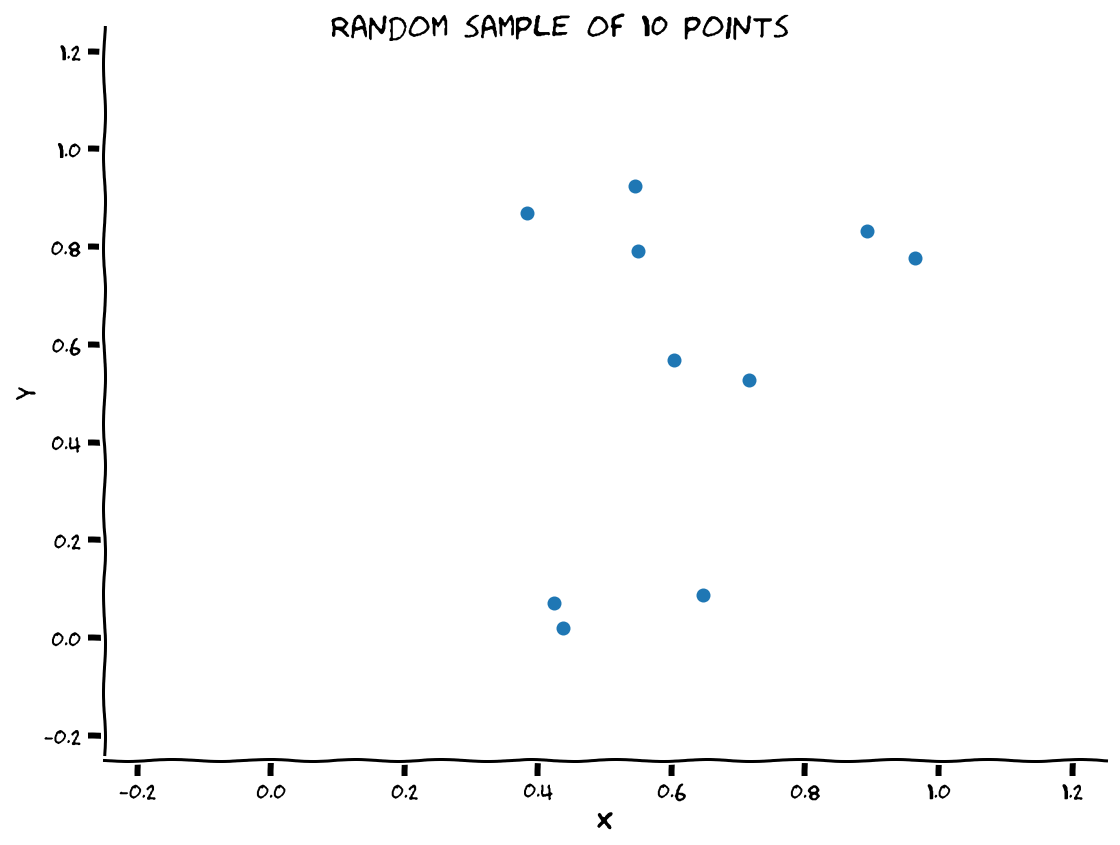

In [ ]:
def generate_random_sample(num_points):
    """ Generate a random sample containing a desired number of points (num_points)
    in the range [0, 1] using a random number generator object.

     Args:
       num_points (int): number of points desired in random sample

     Returns:
       dataX, dataY (ndarray, ndarray): arrays of size (num_points,) containing x
       and y coordinates of sampled points

     """
    ###################################################################
    ## TODO for students: Draw the uniform numbers
    ###################################################################
    dataX = np.random.uniform(0, 1, size=(num_points,)) #Here we use the library numpy to draw randomly our samples from an uniform distribution.
    dataY = np.random.uniform(0, 1, size=(num_points,))
    
    return dataX, dataY
    ###################################################################

# Set a seed
np.random.seed(0)

# Set number of points to draw
num_points = 10

# Draw random points
dataX, dataY = generate_random_sample(num_points)
    
# Visualize
with plt.xkcd():
    plot_random_sample(dataX, dataY, "Random sample of 10 points")

### Coding exercice 1.2: Gaussian Distribution

The most widely used continuous distribution is probably the Gaussian distribution. It is extremely common across all kinds of statistical analyses. Because of the central limit theorem, many quantities are Gaussian distributed. Gaussians also have some nice mathematical properties that permit simple closed-form solutions to several important problems. 

As a working example, imagine that a human participant is asked to point in the direction where they perceived a sound coming from. As an approximation, we can assume that the variability in the direction/orientation they point towards is Gaussian distributed.

In this exercise, you will implement a Gaussian by filling in the missing portions of code for the function `my_gaussian` below. Gaussians have two parameters. The **mean** $\mu$, which sets the location of its center, and its "scale" or spread is controlled by its **standard deviation** $\sigma$, or **variance** $\sigma^2$ (i.e. the square of standard deviation). **Be careful not to use one when the other is required.**

The equation for a Gaussian probability density function is:
$$
f(x;\mu,\sigma^2)=\mathcal{N}(\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)
$$
In Python $\pi$ and $e$ can be written as `np.pi` and `np.exp` respectively.

As a probability distribution this has an integral of one when integrated from $-\infty$ to $\infty$, however in the following your numerical Gaussian will only be computed over a finite number of points. You therefore need to explicitly normalize it to sum to one yourself based on the `step_size` used. 

You can test your function with $\mu= 1$ and $\sigma = 1.5$

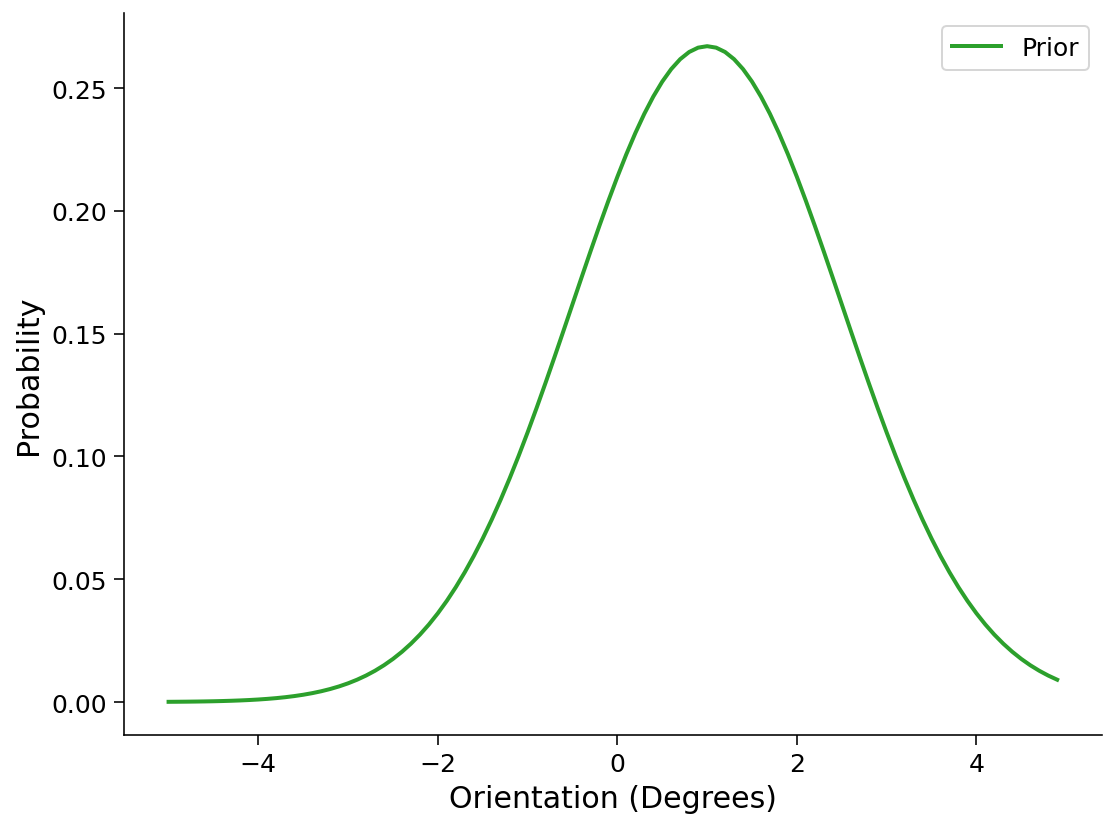

In [9]:
def my_gaussian(x_points, mu, sigma):
    """ Returns normalized Gaussian estimated at points `x_points`, with
    parameters: mean `mu` and standard deviation `sigma`

    Args:
      x_points (ndarray of floats): points at which the gaussian is evaluated
      mu (scalar): mean of the Gaussian
      sigma (scalar): standard deviation of the gaussian

    Returns:
      (numpy array of floats) : normalized Gaussian evaluated at `x`
    """
    ###################################################################
    ## TODO for students: Implement the gaussian equation
    ###################################################################
    step_size = x_points[2] - x_points[1] #We take the step_size as the difference between two points since the step_size is constant
    px = np.exp(-(x_points - mu)**2/ (2 * sigma**2))/np.sqrt(2* np.pi * sigma**2) #Here be careful about the parenthesis so each term is at the right place
 
    #Do not forget to normalize
    px = px/sum(px*step_size) #In order to normalize we divide each value by the approximation of the integral (Riemann sum)
    
    return px
#Choose some parameters
mu = 1
sigma = 1.5
   
###################################################################
#Create data  
step_size = 0.1
x_points = np.arange(-5, 5, step_size)

#Generate the Gaussian
Gaussian = my_gaussian(x_points, mu, sigma)

#Visualise
my_plot_single(x_points, Gaussian)

*Example output:*


<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/TP1_ex1.PNG>

Questions:
* What changes do you observe by varying the mean ?
* What changes do you observe by varying the variance ?

## Section 2: Statistical inference
The goal of this section is to explain how it is possible to do inference by inverting the generative process.

By completing the exercises in this tutorial, you should:
* understand what the likelihood function is, and have some intuition of why it is important
* know how to summarise the Gaussian distribution using mean and variance 
* know how to maximise a likelihood function
* be able to do simple inference in both classical and Bayesian ways

### Section 2.1: Basic rules of probability

Definitions: 
* $P(A) \in [ \,0,1 ]\,$ is the probability that event A is true.
* $P(\neg\, A) = 1 - P(A)$ is the **complementary probability** of the event A.
* $P(A \cap B) = P(A | B)  P(B) = P(B | A)P(A) = P(A,B)$ is the **joint probability** of events A and B. Meaning both events are true.
* $P(A | B) = P(A \cap B)/P(B)$ is the **conditional probability** of the event A being true given the event B is true.
* $P(A) = \sum_{B} P(A,B) = \sum_B P(A|B)P(B)$ is the **marginal probability** of the event A.

### Math exercice 2.1: Example
In order to check if those formula are clear to you, let's take a small example to illustrate them.

Imagine that for the past 10 years, hundreds of students' opinions on the LGBIO2060 course have been gathered aswell as if they have pass the exam. It turns out that on average 60% of the students actually enjoyed the course and 30% succeed at the exam (Those numbers are fictional).

We will use the following notations:

$P(E)=0.6$ is the probability that students enjoyed the course.

$P(S)=0.3$ is the probability that students succeed at the exam.

#### A) Product
Assuming that enjoying the course and passing the exam are two indepedent events, what is the probability that a randomly chosen student enjoyed the course and passed the exam ? i.e $P(E \cap S)$

In [ ]:
#Enter your answer here
p_joint = 0.18

In [ ]:
# @title Test your answer
if p_joint == 0.18:
    print('Your answer is correct, congratulations !!!')
else:
    print('Ho :( Your answer is not the expected one')

Your answer is correct, congratulations !!!


#### B) Joint probability
Unfortunately for you, Clemence tells you that the two variables are not independent. She gives you the following useful information: of those student that enjoyed the course, only 20 percent also succeeded in the exam, i.e. the probability of a student succeeding in the exam given that he enjoyed the course is $P(S|E)=0.2$.

Given this new information, what is the probability that a randomly chosen student succeeds in the exam and enjoys the course ?

In [ ]:
#Enter your answer here
p_joint_not_independent = 0.12

In [ ]:
# @title Test your answer 
if p_joint_not_independent == 0.12:
    print('Your answer is correct, congratulations !!!')
else:
    print('Ho :( Your answer is not the expected one')

Your answer is correct, congratulations !!!


#### C) Conditional probability
You ask a random student that followed this course a few years ago and you find out that he obtained the grade of 17. What is the probability that he enjoyed the course $P(E|S)$?

In [ ]:
#Enter your answer here 
p_cond = 0.4

In [ ]:
# @title Test your answer 
if p_cond == 0.4:
    print('Your answer is correct, congratulations !!!')
else:
    print('Ho :( Your answer is not the expected one')

Your answer is correct, congratulations !!!


#### D) Marginal probability
Let's check that everything has been done correctly. Based on our knowledge about the conditional probabilities, we should be able to use marginalisation to recover the marginal probability of a random student to succeed the course. We know that it should be $P(E)=0.6$.

Check that you obtain the same result based on conditional probabilities for $P(E|S)$ and $P(E|\neg S)$ using the marginalization formula. You can use $P(E|\neg S)=0.685$ but it is a good exercice to check if you can compute it by yourself.

In [ ]:
#Enter your code here
p_cond_succeed = 0.4
p_cond_notSucceed = 0.685

p_enjoy = p_cond_succeed * 0.3 + p_cond_notSucceed * 0.7
#Visualise the result
print(p_enjoy)

0.5994999999999999


In [ ]:
# @title Test your answer
p_enjoy_true = 0.6
if (np.abs(p_enjoy - p_enjoy_true)<0.015):
    print('Your answer is correct, congratulations !!!')
else:
    print('Ho :( Your answer is not the expected one')

Your answer is correct, congratulations !!!


### Section 2.2 Likelihoods
Most of the times when you are trying to model something you have two things:

* Observations/data **x**.
* A probabilistic model $P(x|\theta)$

And your goal is to estimate the hidden properties $\theta$ that gave rise to the data **x**.

For example, if your probabilistic model is a Gaussian distribution $\mathcal{N}(x_i,\mu,\sigma)$ your goal is to find the parameters $\theta=\{\mu,\sigma\}$ that maximise the probability that your data **x** were obtained given those parameters.

A classical method to achieve such result is the **maximum likelihood**, which consists to maximise the probability of model with regard to $\theta$.

$$\hat\theta = argmax \, P(x|\theta)$$

This equation translates the fact the that you want to find the parameters $\theta$ that maximize the probability that your data **x** were indeed obtained by your probabilistic model.

In other words, if we do not know the parameters $\mu$, $\sigma$ that generated the data, we can try to **infer** which parameter values (given our model) gives the best (highest) likelihood. This is what we call statistical inference: trying to infer what parameters make our observed data the most likely or probable?

### Coding Exercise 2.2: Computing likelihood

Let's start with computing the likelihood of some set of data points being drawn from a Gaussian distribution with a mean and variance we choose. 



As multiplying small probabilities together can lead to very small numbers, it is often convenient to report the *logarithm* of the likelihood. This is just a convenient transformation and as logarithm is a monotonically increasing function this does not change what parameters maximise the function.

Here you have to implement the log-likelihood in `compute_likelihood_normal`:
$$Log \, Likelihood = \sum_{i=1}^n log\left(P(x_i)\right)$$


In [ ]:
def compute_likelihood_normal(x, mean_val, standard_dev_val):
  """ Computes the log-likelihood values given a observed data sample x, and
  potential mean and variance values for a normal distribution

    Args:
      x (ndarray): 1-D array with all the observed data
      mean_val (scalar): value of mean for which to compute likelihood
      standard_dev_val (scalar): value of standard deviation for which to compute likelihood

    Returns:
      likelihood (scalar): value of likelihood for this combination of means/variances
  """

  ###################################################################
  ## TODO for student
  ###################################################################

  # Get probability of each data point (use norm.pdf from scipy stats)
  p_data = norm.pdf(x, mean_val, standard_dev_val) #we use the function available in the scipy library to generate the pdf of a normal distribution

  # Compute likelihood (sum over the log of the probabilities)
  likelihood = np.sum(np.log(p_data)) #We compute the likelihood based on the formula

  return likelihood

# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

# Compute likelihood for a guessed mean/standard dev
guess_mean = 4
guess_standard_dev = .1
likelihood = compute_likelihood_normal(x, guess_mean, guess_standard_dev)
print(likelihood)

-92904.81398544145


You should get a likelihood of -92904.81. This is somewhat meaningless to us! For it to be useful, we need to compare it to the likelihoods computing using other guesses of the mean or standard deviation. The visualization below shows us the likelihood for various values of the mean and the standard deviation. Essentially, we are performing a rough grid-search over means and standard deviations.  What would you guess as the true mean and standard deviation based on this visualization? 

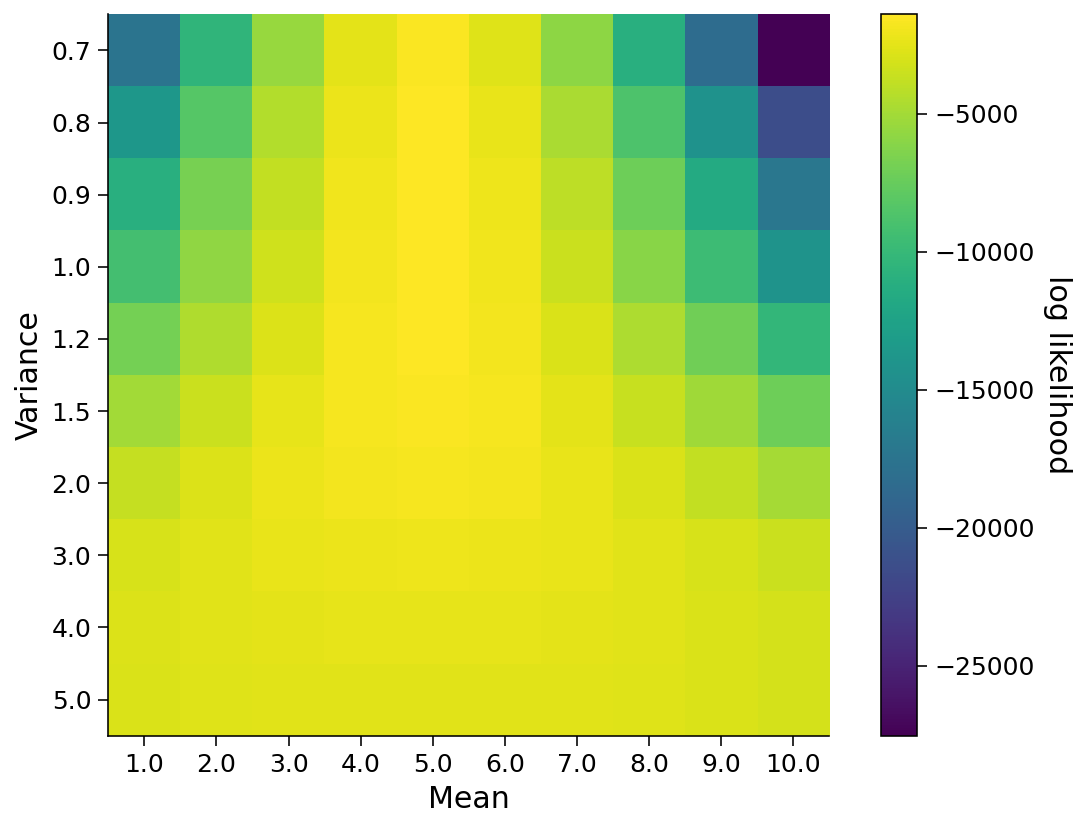

In [ ]:
# @title Execute to visualize likelihoods

# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))


# Compute likelihood for different mean/variance values
mean_vals = np.linspace(1, 10, 10) # potential mean values to ry
standard_dev_vals = np.array([0.7, 0.8, 0.9, 1, 1.2, 1.5, 2, 3, 4, 5]) # potential variance values to try

# Initialise likelihood collection array
likelihood = np.zeros((mean_vals.shape[0], standard_dev_vals.shape[0]))

# Compute the likelihood for observing the gvien data x assuming
# each combination of mean and variance values
for idxMean in range(mean_vals.shape[0]):
  for idxVar in range(standard_dev_vals .shape[0]):
    likelihood[idxVar,idxMean]= sum(np.log(norm.pdf(x, mean_vals[idxMean],
                                              standard_dev_vals[idxVar])))

# Uncomment once you've generated the samples and compute likelihoods
xspace = np.linspace(0, 10, 100)
plot_likelihoods(likelihood, mean_vals, standard_dev_vals)

### Section 2.2.1: Searching for best parameters

We want to do inference on this data set, i.e. we want to infer the parameters that most likely gave rise to the data given our model. Intuitively that means that we want as good as possible a fit between the observed data and the probability distribution function with the best inferred parameters. We can search for the best parameters manually by trying out a bunch of possible values of the parameters, computing the likelihoods, and picking the parameters that resulted in the highest likelihood. 

#### Interactive Demo 2.2: Maximum likelihood inference

Try to see how well you can fit the probability distribution to the data by using the demo sliders to control the mean and standard deviation parameters of the distribution. We will visualize the histogram of data points (in blue) and the Gaussian density curve with that mean and standard deviation (in red). Below, we print the log-likelihood.

- What (approximate) values of mu and sigma result in the best fit?
- How does the value below the plot (the log-likelihood) change with the quality of fit?

In [ ]:
# @title Make sure you execute this cell to enable the widget and fit by hand!
# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
vals = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

def plotFnc(mu,sigma):
  loglikelihood= sum(np.log(norm.pdf(vals,mu,sigma)))
  #calculate histogram

  #prepare to plot
  fig, ax = plt.subplots()
  ax.set_xlabel('x')
  ax.set_ylabel('probability')

  #plot histogram
  count, bins, ignored = plt.hist(vals,density=True)
  x = np.linspace(0,10,100)

  #plot pdf
  plt.plot(x, norm.pdf(x,mu,sigma),'r-')
  plt.show()
  print("The log-likelihood for the selected parameters is: " + str(loglikelihood))

#interact(plotFnc, mu=5.0, sigma=2.1);
#interact(plotFnc, mu=widgets.IntSlider(min=0.0, max=10.0, step=1, value=4.0),sigma=widgets.IntSlider(min=0.1, max=10.0, step=1, value=4.0));
interact(plotFnc, mu=(0.0, 15.0, 0.1),sigma=(0.1, 5.0, 0.1));

interactive(children=(FloatSlider(value=7.5, description='mu', max=15.0), FloatSlider(value=2.5000000000000004…

### Section 2.2.2: Analytical solution

Sometimes, things work out well and we can come up with formulas for the maximum likelihood estimates of parameters. We won't get into this further but basically we could set the derivative of the likelihood to 0 (to find a maximum) and solve for the parameters. This won't always work but for the Gaussian distribution, it does.

Specifically , the special thing about the Gaussian is that mean and standard deviation of the random sample can effectively approximate the two parameters of a Gaussian, $\mu, \sigma$.


Hence using the  mean, $\bar{x}=\frac{1}{n}\sum_i x_i$, and variance, $\bar{\sigma}^2=\frac{1}{n} \sum_i (x_i-\bar{x})^2 $ of the sample should give us the best/maximum likelihood.

Complete the missing parts in the following piece of code to observe what are the estimate you find with the analytical method.

In [ ]:
# Set random seed
np.random.seed(0)

# Generate data
true_mean = 5
true_standard_dev = 1
n_samples = 1000
x = np.random.normal(true_mean, true_standard_dev, size = (n_samples,))

###################################################################
  ## TODO for student
###################################################################
# Compute and print sample means and standard deviations
sample_mean = np.sum(x)/n_samples
sample_std = np.sum((x - sample_mean)**2)/ n_samples

print("This is the sample mean as estimated by analytical method: " + str(sample_mean))
print("This is the sample standard deviation as estimated by analytical method: " + str(sample_std))

This is the sample mean as estimated by analytical method: 4.9547432925098045
This is the sample standard deviation as estimated by analytical method: 0.9742344563121543


### Section 2.2.3: Numerical optimization to find parameters
Sometimes, it is not possible to find the optimal parameters analitycally and numerical methods must be used.


Let's again assume that we have a data set, $\mathbf{x}$, assumed to be generated by a normal distribution.
We want to maximise the likelihood of the parameters $\mu$ and $\sigma^2$. We can do so using a couple of tricks:

*   Using a log transform will not change the maximum of the function, but will allow us to work with very small numbers that could lead to problems with machine precision.
*   Maximising a function is the same as minimising the negative of a function, allowing us to use the minimize optimisation provided by scipy.

The optimisation could be done using `sp.optimize.minimize`, which does a version of gradient descent (there are hundreds of ways to do numerical optimisation, we will not cover these here!).

---
# Section 3: Bayesian Inference

For Bayesian inference we do not focus on the likelihood function $L(y)=P(x|y)$, but instead focus on the posterior distribution: 

$$P(y|x)=\frac{P(x|y)P(y)}{P(x)}$$

which is composed of the **likelihood** function $P(x|y)$, the **prior** $P(y)$ and a normalising term $P(x)$

hile there are other advantages to using Bayesian inference (such as the ability to derive Bayesian Nets), we will start by focusing on the role of the prior in inference. Does including prior information allow us to infer parameters in a better way?

### Think! 3.1: Bayesian inference with Gaussian distribution

In the above sections we performed inference using maximum likelihood, i.e. finding the parameters that maximised the likelihood of a set of parameters, given the model and data.

We will now repeat the inference process, but with an added Bayesian prior, and compare it to the "classical" inference (maximum likelihood) process we did before (Section 2).

For the prior we start by guessing a mean of 5 (mean of previously observed data points 4 and 6) and variance of 1 (variance of 4 and 6). We use a trick (not detailed here) that is a simplified way of applying a prior, that allows us to just add these 2 values (pseudo-data) to the real data.

See the visualization below that shows the mean and standard deviation inferred by our classical maximum likelihood approach and the Bayesian approach for different numbers of data points.

Remembering that our true values are $\mu = 5$, and $\sigma^2 = 1$, how do the Bayesian inference and classical inference compare?

The mean of the data comprising the prior is: 5.0
The variance of the data comprising the prior is: 1.0


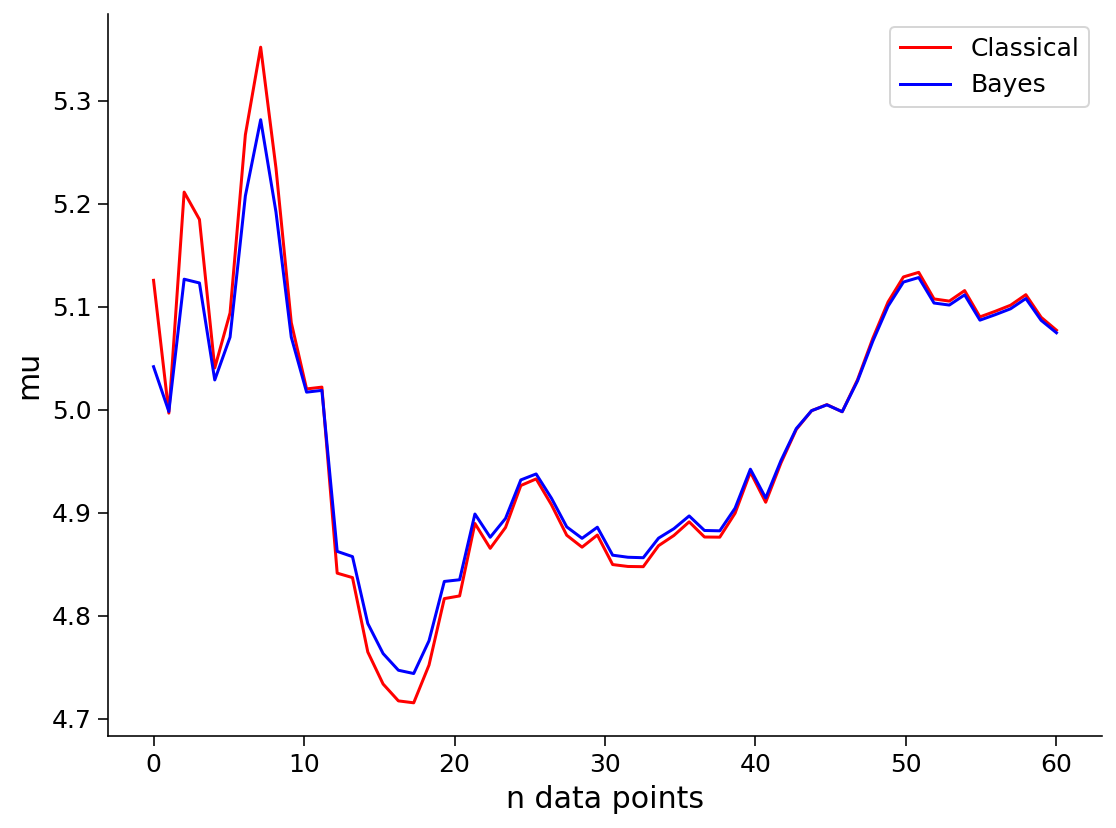

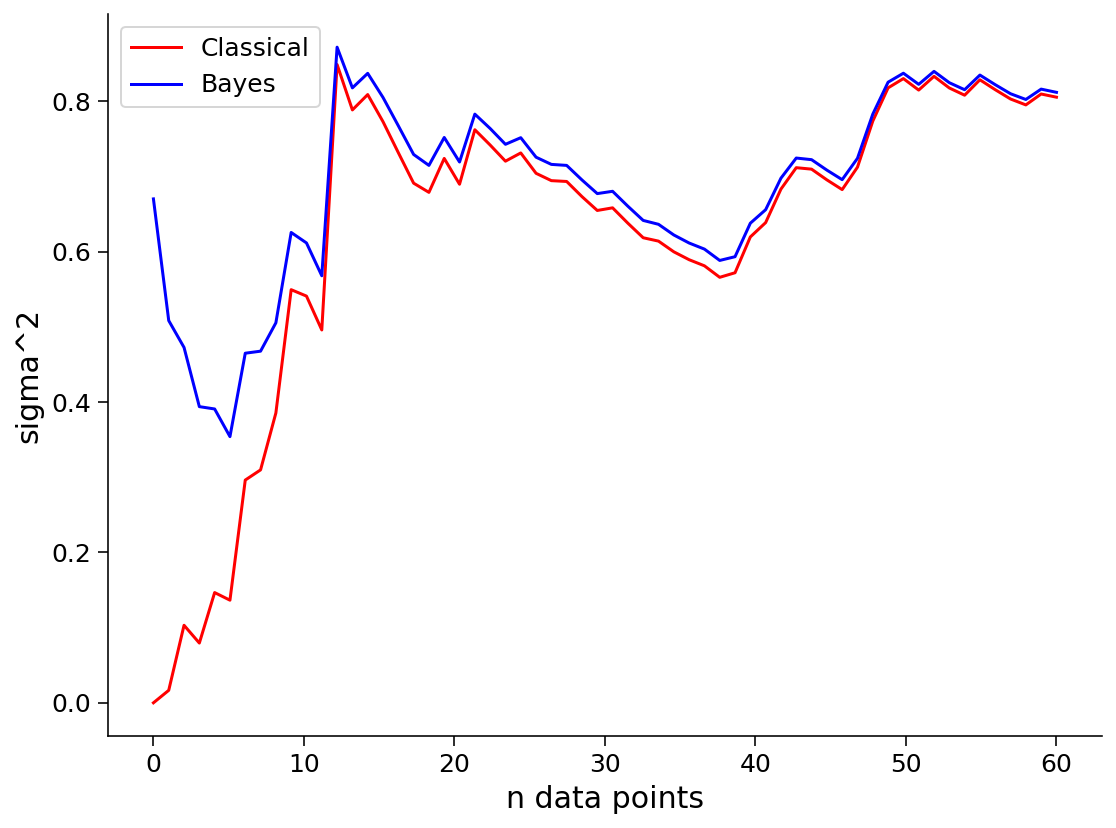

In [ ]:
# @title Execute to visualize inference

def classic_vs_bayesian_normal(mu, sigma, num_points, prior):
  """ Compute both classical and Bayesian inference processes over the range of
  data sample sizes (num_points) for a normal distribution with parameters
  mu,sigma for comparison.

  Args:
    mu (scalar): the mean parameter of the normal distribution
    sigma (scalar): the standard deviation parameter of the normal distribution
    num_points (int): max number of points to use for inference
    prior (ndarray): prior data points for Bayesian inference

  Returns:
    mean_classic (ndarray): estimate mean parameter via classic inference
    var_classic (ndarray): estimate variance parameter via classic inference
    mean_bayes (ndarray): estimate mean parameter via Bayesian inference
    var_bayes (ndarray): estimate variance parameter via Bayesian inference
  """

  # Initialize the classical and Bayesian inference arrays that will estimate
  # the normal parameters given a certain number of randomly sampled data points
  mean_classic = np.zeros(num_points)
  var_classic = np.zeros(num_points)

  mean_bayes = np.zeros(num_points)
  var_bayes = np.zeros(num_points)

  for nData in range(num_points):

    random_num_generator = default_rng(0)
    x = random_num_generator.normal(mu, sigma, nData + 1)

    # Compute the mean of those points and set the corresponding array entry to this value
    mean_classic[nData] = np.mean(x)

    # Compute the variance of those points and set the corresponding array entry to this value
    var_classic[nData] = np.var(x)

    # Bayesian inference with the given prior is performed below for you
    xsupp = np.hstack((x, prior))
    mean_bayes[nData] = np.mean(xsupp)
    var_bayes[nData] = np.var(xsupp)

  return mean_classic, var_classic, mean_bayes, var_bayes

# Set random seed
np.random.seed(0)

# Set normal distribution parameters, mu and sigma
mu = 5
sigma = 1

# Set the prior to be two new data points, 4 and 6, and print the mean and variance
prior = np.array((4, 6))
print("The mean of the data comprising the prior is: " + str(np.mean(prior)))
print("The variance of the data comprising the prior is: " + str(np.var(prior)))

mean_classic, var_classic, mean_bayes, var_bayes = classic_vs_bayesian_normal(mu, sigma, 60, prior)
plot_classical_vs_bayesian_normal(60, mean_classic, var_classic, mean_bayes, var_bayes)

#### Discuss the impact of the prior on the on the inference of the mean and the variance.

Hopefully you can see that the blue line stays a little closer to the true values ($\mu=5$, $\sigma^2=1$).
 Having a simple prior in the Bayesian inference process (blue) helps to regularise
 the inference of the mean and variance parameters when you have very little data,
 but has little effect with large data sets. You can see that as the number of data points
 (x-axis) increases, both inference processes (blue and red lines) get closer and closer
 together, i.e. their estimates for the true parameters converge as sample size increases.